# Google Trends insight in understanding what drives Norwegians into purchasing an electric vehicle
Authors: 
- 270226 - Max Chevron 
- 321733 - Shasha Jiang 
- 314205 - Jostein Leirgulen 

Date: 03.12.2020 

### Abstract:

Norway is well advanced compared to other countries in the expansion of its electric vehicle (EV) fleet thanks to strong incentives (100% tax for combustion vehicles which are exempted for EV). It has even reached the top place in total EV sales despite its country size. Understanding the evolution of EV car sales in Norway could help predicting future sales in other countries. 

Now that we have a working model to assess the predictive power of Google Trends on a certain output, we will then extend this on investigating which set of indicators best improve the short-term prediction of a Norway EV sales. The indicators will be grouped in categories such as environment, car models, infrastructure or policy related. Additionally, we will assess the impact of corner-stone events such as the Paris Climate Accord, the release of the Tesla model 3 as well as the implementation of tax-cuts for EVs in Norway on car sales. All of this will help us assess which category of indicators/events influence most the consumer propensity to switch from combustion to electric.

### Research Questions:

- Which category of indicators influence most EV sales in Norway?  Is it environment, car models, infrastructure (charging stations) or government policies?
- Which event influenced most EV sales in Norway (the Paris Climate Accord, the release of the Tesla model 3 or the implementation of tax-cuts for EVs in Norway)?
- Is there a coherent correlation between the answers of both questions above? 

### Proposed dataset:

1) Opplysningsrådet for Veitrafikk - Road Traffic Information Council

- https://ofv.no/ 
- The data should be bought but as students we managed to request it for free
- We have not accessed the data yet, so we do not know the full content of it and cannot infer its size yet. Most probably it would be at around 100 rows (1 per month for 10 years).

2) Google Trends:

- https://trends.google.com/trends
- We will pick several indicators and investigate which ones help us best in predicting. Indicators will be grouped in these categories:
  - Environment
  - Car models
  - Infrastructure (charging stations)
  - Government policies

### Methods:

We will: 

- use the same method in the paper for Motor Vehicles and Parts,  select relevant terms for google trends
- do several experiments to find a suitable match
- use the expanding window to train the data and make prediction

The models will be:

- Base model features: 1 month lag + 12 month lag
- Indicators model features: 
  - Base + environment related indicators
  - Base + car model related indicators
  - Base + infrastructure related indicators
  - Base + government policies related indicators
  - Base + all indicators
- Indicators and events model features (Discontinuous regression model): 
  - Base + all indicators + Paris Climate accord passed? [0,1] + Tesla model 3 released? [0,1] + Norway EV tax-cut implemented? [0,1]

In [1]:
!pip install pytrends

In [2]:
import pandas as pd 
from dateutil import relativedelta as rdelta
from datetime import datetime, date
import time
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.stats import diagnostic
import statsmodels.formula.api as smf
from pytrends.request import TrendReq

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Step 1 - EV sales data wrangling

In [3]:
sales = pd.read_csv('EV_sales_norway.csv',sep=';')

In [4]:
sales['weekday'] = ''
pd.to_datetime(sales['weekday'])
for index, row in sales.iterrows():
    # minus 1 because the dataset week system goes from 1 to 53 instead of 0 to 52, day start from sunday 0 to macth google trend
    sales.weekday[index] = datetime.strptime('{} {} 0'.format(row.year, row.week-1), '%Y %W %w').strftime("%Y-%m-%d") 
sales.weekday = pd.to_datetime(sales.weekday, format='%Y-%m-%d')
#compute market share for electric cars
sales['market_share_electric'] = sales['electric']/(sales['other'] + sales['electric'])
sales

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,year,week,other,electric,weekday,market_share_electric
0,2010,1,17,0,2010-01-03,0.000000
1,2010,2,2776,0,2010-01-10,0.000000
2,2010,3,1953,0,2010-01-17,0.000000
3,2010,4,2078,0,2010-01-24,0.000000
4,2010,5,2873,0,2010-01-31,0.000000
...,...,...,...,...,...,...
572,2020,44,1749,1869,2020-11-01,0.516584
573,2020,45,961,1291,2020-11-08,0.573268
574,2020,46,1174,1435,2020-11-15,0.550019
575,2020,47,1259,1591,2020-11-22,0.558246


Text(0, 0.5, 'Weekly car sales')

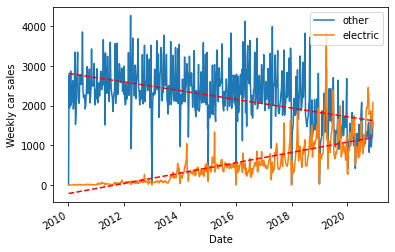

In [5]:
sales.plot('weekday', y=["other", "electric"])

# calc the trendline
z_other = np.polyfit(sales.index, sales.other, 1)
z_elec = np.polyfit(sales.index, sales.electric, 1)
p_other = np.poly1d(z_other)
p_elec = np.poly1d(z_elec)
plt.plot(sales.weekday,p_other(sales.index),"r--")
plt.plot(sales.weekday,p_elec(sales.index),"r--")
plt.xlabel('Date')
plt.ylabel('Weekly car sales')

Text(0.5, 1.0, 'EVs in Norway')

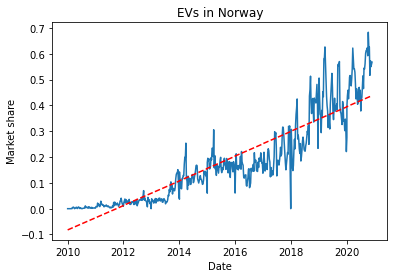

In [6]:
x = sales.weekday
y = sales.electric/(sales.electric+sales.other)
plt.plot(x,y)

# calc the trendline
z_elec = np.polyfit(sales.index, y, 1)
p_elec = np.poly1d(z_elec)
plt.plot(x,p_elec(sales.index),"r--")
plt.xlabel('Date')
plt.ylabel('Market share')
plt.title('EVs in Norway')

### Step 2 - Google trend data import and wrangling

In [7]:
'''
Function goal:      Import Google Trends data
Function inputs:    kw = Keyword list 
                    hl = Host language of Google Trends
                    tz = Timezone (UTC offset in miunutes)
                    geo = Country abreviation to search
                    dates = Timespan to search
                    eps = maximum propensity difference in matching
Function outputs:   pytrends = full pytrends format dataset
                    interest_over_time_df = Dataframe containing the interest evolution for each keyword
'''


def convert_to_date(satrt_year,end_year):
      start = satrt_year.strftime("%Y-%m-%d")
      end = end_year.strftime("%Y-%m-%d")
      dates = start + ' ' + end
      return dates

def split_data_into_year(date_start, date_end):
    years_expand = []
    start_year = date_start
    while abs(rdelta.relativedelta(start_year,date_end).years) >0 :
      one_year = rdelta.relativedelta(weeks=+50)
      end_year = start_year + one_year
    
      years_expand += [convert_to_date(start_year,end_year)]

      #update start_year
      one_week = rdelta.relativedelta(weeks=+1)
      start_year = end_year + one_week

    years_expand += [convert_to_date(start_year,date_end)]
    return years_expand

def build_GT_weekly_data(kw, hl, tz, geo, date_start, date_end):
    yrs = split_data_into_year(date_start, date_end)

    pytrends = TrendReq(hl=hl, tz=tz)
    pytrends.build_payload(kw_list=kw, cat=0, timeframe=yrs[0], geo=geo, gprop='')
    # Interest Over Time
    interest_over_time_df = pytrends.interest_over_time()
    interest_over_time_df.drop(columns='isPartial', inplace=True)

    for dates in yrs[1:]:
      pytrends = TrendReq(hl=hl, tz=tz)
      pytrends.build_payload(kw_list=kw, cat=0, timeframe=dates, geo=geo, gprop='')
      
      # Interest Over Time
      interest_over_time_df1 = pytrends.interest_over_time()
      interest_over_time_df1.drop(columns='isPartial', inplace=True)
      interest_over_time_df = pd.concat([interest_over_time_df, interest_over_time_df1])

    return pytrends, interest_over_time_df

In [8]:
UTC_offset = 60 # Minutes for Norway (UTC+1)
host_language = 'en_US'
# keywords related to category: economical 
kw_eco = ["Elbil bompenger", "Elbil avgift", "Elbil pris", "Elbil fordeler", "Bompenger"] # REMOVED:, "Bompenger pris", "Parkering pris", "Elbil parkering"] 
# keywords related to category: EV models (top 10 EV models sold in Norway with Tesla models grouped together as 'Tesla')
kw_evm = ["Tesla", "Nissan Leaf","Volkswagen e-Golf", "Bmw I3", "Kia Soul"] # REMOVED:, "Renault Zoe", "Audi E-tron", "Hyundai Ioniq"] 
# keywords related to category: range anxiety 
kw_ran = ["Elbil lading", "Elbil ladestasjoner", "Ladestasjoner", "Hurtiglading", "Elbil rekkevidde"] # REMOVED:, "Tesla supercharger"] 
# keywords related to category: environement 
kw_env = ["Karbonavtrykk", "Luftkvalitet", "CO2", "CO2 bil", "CO2 utslipp"] 
date_start = date(2009,12,28) # Sales dataset Timespan
date_end = date(2020,11,29)
country_abbreviation = 'NO' #Norway abreviation

pytrends_eco, interest_eco = build_GT_weekly_data(kw_eco, host_language, UTC_offset, country_abbreviation, date_start, date_end)
pytrends_evm, interest_evm = build_GT_weekly_data(kw_evm, host_language, UTC_offset, country_abbreviation, date_start, date_end)
pytrends_ran, interest_ran = build_GT_weekly_data(kw_ran, host_language, UTC_offset, country_abbreviation, date_start, date_end)
pytrends_env, interest_env = build_GT_weekly_data(kw_env, host_language, UTC_offset, country_abbreviation, date_start, date_end)

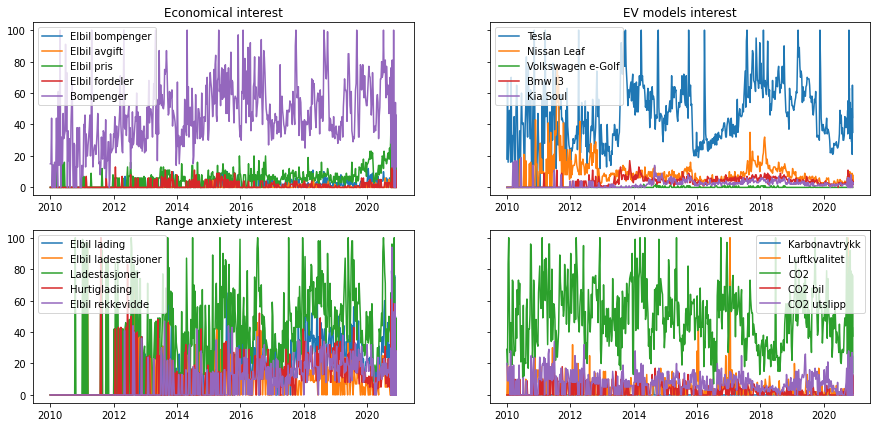

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(15,7), sharey=True)

axs[0,0].plot(interest_eco)
axs[0,0].set_title("Economical interest")
axs[0,0].legend(kw_eco)

axs[0,1].plot(interest_evm)
axs[0,1].set_title("EV models interest")
axs[0,1].legend(kw_evm)

axs[1,0].plot(interest_ran)
axs[1,0].set_title("Range anxiety interest")
axs[1,0].legend(kw_ran)

axs[1,1].plot(interest_env)
axs[1,1].set_title("Environment interest")
axs[1,1].legend(kw_env)

### Step 3 - Build key events dataset

In [10]:
# Economical related dates which penalises combustion vehicles (in favor of EV)
dates_eco = {"Climate settlement announcement":"2012-04-24",
             "Kyoto agreement second term":"2013-05-31"}

# EV model key releas dates
# Unknown date of the month for dates_evm so set to 15
dates_evm = {"Tesla model 3 first release":"2019-07-15",
             "Nissan Leaf first release":"2010-12-15"}

# Range anxiety mitigation key dates
dates_ran = {"Tesla supercharging system start":"2013-07-01"}

# Rising environmental awarness key dates
dates_env = {"Paris agreement anouncement":"2015-01-04",
             "Paris agreement updated emission cuts":"2020-02-27"}

### Step 4.1 -  Indicator based models

#### Make data ready to train
- Using logarithm of sales
- Shifting the sales data for last year and last month, to build the AR-1 Model as defined in the paper y= b1*y_t-1 + b2*y_t-12 + e

#### Train indicator based models
- Indicators model features:
     - Base + environment related indicators
     - Base + car model related indicators
     - Base + infrastructure related indicators
     - Base + government policies related indicators
     - Base + all indicators

In [11]:
sales_base = sales.copy()
#replace 0 to a samll number bigger than 1 so that log can be defined
sales_base.market_share_electric = sales_base.market_share_electric.replace(0, 0.5)
sales_base.market_share_electric = np.log(sales_base.market_share_electric)
sales_base['last_month_electric']=sales_base.market_share_electric.shift(1)
sales_base['last_year_electric']=sales_base.market_share_electric.shift(12)

In [12]:
sales_base

,year,week,other,electric,weekday,market_share_electric,last_month_electric,last_year_electric
0,2010,1,17,0,2010-01-03,-0.693147,NaN,NaN
1,2010,2,2776,0,2010-01-10,-0.693147,-0.693147,NaN
2,2010,3,1953,0,2010-01-17,-0.693147,-0.693147,NaN
3,2010,4,2078,0,2010-01-24,-0.693147,-0.693147,NaN
4,2010,5,2873,0,2010-01-31,-0.693147,-0.693147,NaN
...,...,...,...,...,...,...,...,...
572,2020,44,1749,1869,2020-11-01,-0.660518,-0.467839,-0.765420
573,2020,45,961,1291,2020-11-08,-0.556402,-0.660518,-0.608043
574,2020,46,1174,1435,2020-11-15,-0.597802,-0.556402,-0.614676
575,2020,47,1259,1591,2020-11-22,-0.582956,-0.597802,-0.577285


In [13]:
'''
add google trend data to base data
'''
def add_trend_data(base,extend):
    extend = extend.reset_index()
    data = base.merge(extend, left_on='weekday', right_on='date')
    return data.drop(["date"], axis=1) 


In [14]:
sales_eco = add_trend_data(sales_base,interest_eco)
sales_env = add_trend_data(sales_base,interest_env)
sales_evm = add_trend_data(sales_base,interest_evm)
sales_ran = add_trend_data(sales_base,interest_ran)

trend_index = [interest_env,interest_evm,interest_ran]
sales_all = sales_eco
for i in trend_index:
    sales_all = add_trend_data(sales_all,i)

Train models

In [15]:
base_mod = smf.ols(formula=' market_share_electric	~ last_month_electric + last_year_electric', data=sales_base).fit()
print(base_mod.summary())

                              OLS Regression Results                             
Dep. Variable:     market_share_electric   R-squared:                       0.829
Model:                               OLS   Adj. R-squared:                  0.828
Method:                    Least Squares   F-statistic:                     1361.
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):          3.75e-216
Time:                           00:12:09   Log-Likelihood:                -540.47
No. Observations:                    565   AIC:                             1087.
Df Residuals:                        562   BIC:                             1100.
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

In [16]:
def model_formula(base,data,idx):
  formula = base
  f = '+Q("{}")'
  for c in data.columns[idx:]:
    formula += f.format(c)
  return formula 

In [17]:
base_formula = 'market_share_electric ~ last_month_electric + last_year_electric'
# from 7 th indx we need to add Q() in formula
idx = 8

In [18]:
eco_form = model_formula(base_formula,sales_eco,idx)
eco_mod = smf.ols(formula=eco_form, data=sales_eco).fit()
print(eco_mod.summary())

                              OLS Regression Results                             
Dep. Variable:     market_share_electric   R-squared:                       0.834
Model:                               OLS   Adj. R-squared:                  0.831
Method:                    Least Squares   F-statistic:                     390.7
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):          6.00e-208
Time:                           00:12:09   Log-Likelihood:                -522.75
No. Observations:                    554   AIC:                             1061.
Df Residuals:                        546   BIC:                             1096.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
In

In [19]:
env_form = model_formula(base_formula,sales_env,idx)
env_mod = smf.ols(formula=env_form, data=sales_env).fit()
print(env_mod.summary())

                              OLS Regression Results                             
Dep. Variable:     market_share_electric   R-squared:                       0.828
Model:                               OLS   Adj. R-squared:                  0.826
Method:                    Least Squares   F-statistic:                     376.1
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):          3.16e-204
Time:                           00:12:09   Log-Likelihood:                -531.46
No. Observations:                    554   AIC:                             1079.
Df Residuals:                        546   BIC:                             1113.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Inte

In [20]:
evm_form = model_formula(base_formula,sales_evm,idx)
evm_mod = smf.ols(formula=evm_form, data=sales_evm).fit()
print(evm_mod.summary())

                              OLS Regression Results                             
Dep. Variable:     market_share_electric   R-squared:                       0.832
Model:                               OLS   Adj. R-squared:                  0.829
Method:                    Least Squares   F-statistic:                     385.0
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):          1.66e-206
Time:                           00:12:09   Log-Likelihood:                -526.12
No. Observations:                    554   AIC:                             1068.
Df Residuals:                        546   BIC:                             1103.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

In [21]:
ran_form = model_formula(base_formula,sales_ran,idx)
ran_mod = smf.ols(formula=ran_form, data=sales_ran).fit()
print(ran_mod.summary())

                              OLS Regression Results                             
Dep. Variable:     market_share_electric   R-squared:                       0.833
Model:                               OLS   Adj. R-squared:                  0.831
Method:                    Least Squares   F-statistic:                     389.3
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):          1.32e-207
Time:                           00:12:09   Log-Likelihood:                -523.54
No. Observations:                    554   AIC:                             1063.
Df Residuals:                        546   BIC:                             1098.
Df Model:                              7                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [22]:
all_form = model_formula(base_formula,sales_all,idx)
all_mod = smf.ols(formula=all_form, data=sales_all).fit()
print(all_mod.summary())

                              OLS Regression Results                             
Dep. Variable:     market_share_electric   R-squared:                       0.848
Model:                               OLS   Adj. R-squared:                  0.841
Method:                    Least Squares   F-statistic:                     134.4
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):          1.01e-200
Time:                           00:12:09   Log-Likelihood:                -498.02
No. Observations:                    554   AIC:                             1042.
Df Residuals:                        531   BIC:                             1141.
Df Model:                             22                                         
Covariance Type:               nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

### Step 4.2 
#### Make data ready to train
- 1 column for each date with 0 before, 1 after date

####Train indicator+Events based models
- Indicators and events model features (Discontinuous regression model): 
  - Base + economic related key dates 
  - Base + car model related key dates
  - Base + range anxiety related key dates
  - Base + environment related key dates
  - Base + all key dates

In [23]:
# Economical related dates which penalises combustion vehicles (in favor of EV)
dates_eco = {"Climate settlement announcement":"2012-04-24",
             "Kyoto agreement second term":"2013-05-31"}

# EV model key releas dates
# Unknown date of the month for dates_evm so set to 15
dates_evm = {"Tesla model 3 first release":"2019-07-15",
             "Nissan Leaf first release":"2010-12-15"}

# Range anxiety mitigation key dates
dates_ran = {"Tesla supercharging system start":"2013-07-01"}

# Rising environmental awarness key dates
dates_env = {"Paris agreement anouncement":"2015-01-04",
             "Paris agreement updated emission cuts":"2020-02-27"}

In [30]:
def add_date_data(base_data,events_dic):
  data = base_data.copy()
  for (event,date) in events_dic.items():
    data[event] =  data.weekday > date
  return data

In [31]:
sales_eco_date = add_date_data(sales_base, dates_eco)
sales_evm_date = add_date_data(sales_base, dates_evm)
sales_env_date = add_date_data(sales_base, dates_env)
sales_ran_date = add_date_data(sales_base, dates_ran)

trend_index = [dates_evm,dates_env,dates_ran]
sales_all_date = sales_eco_date
for i in trend_index:
    sales_all_date = add_date_data(sales_all_date,i)

In [27]:
# !pip install rdd

https://github.com/evan-magnusson/rdd

In [28]:
base_formula = 'market_share_electric ~ last_month_electric + last_year_electric'
# from 8th indx we need to add Q() in formula
idx = 8

In [33]:
eco_form_date = model_formula(base_formula,sales_eco_date,idx)
eco_mod_date = smf.ols(formula=eco_form_date, data=sales_eco_date).fit()
print(eco_mod_date.summary())

                              OLS Regression Results                             
Dep. Variable:     market_share_electric   R-squared:                       0.847
Model:                               OLS   Adj. R-squared:                  0.845
Method:                    Least Squares   F-statistic:                     772.3
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):          2.88e-226
Time:                           00:13:53   Log-Likelihood:                -509.67
No. Observations:                    565   AIC:                             1029.
Df Residuals:                        560   BIC:                             1051.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [34]:
evm_form_date = model_formula(base_formula,sales_evm_date,idx)
evm_mod_date = smf.ols(formula=evm_form_date, data=sales_evm_date).fit()
print(evm_mod_date.summary())

                              OLS Regression Results                             
Dep. Variable:     market_share_electric   R-squared:                       0.842
Model:                               OLS   Adj. R-squared:                  0.841
Method:                    Least Squares   F-statistic:                     748.1
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):          5.23e-223
Time:                           00:15:52   Log-Likelihood:                -517.25
No. Observations:                    565   AIC:                             1044.
Df Residuals:                        560   BIC:                             1066.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [35]:
env_form_date = model_formula(base_formula,sales_env_date,idx)
env_mod_date = smf.ols(formula=env_form_date, data=sales_env_date).fit()
print(env_mod_date.summary())

                              OLS Regression Results                             
Dep. Variable:     market_share_electric   R-squared:                       0.836
Model:                               OLS   Adj. R-squared:                  0.834
Method:                    Least Squares   F-statistic:                     712.0
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):          5.89e-218
Time:                           00:15:58   Log-Likelihood:                -528.99
No. Observations:                    565   AIC:                             1068.
Df Residuals:                        560   BIC:                             1090.
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [36]:
ran_form_date = model_formula(base_formula,sales_ran_date,idx)
ran_mod_date = smf.ols(formula=ran_form_date, data=sales_ran_date).fit()
print(ran_mod_date.summary())

                              OLS Regression Results                             
Dep. Variable:     market_share_electric   R-squared:                       0.843
Model:                               OLS   Adj. R-squared:                  0.842
Method:                    Least Squares   F-statistic:                     1004.
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):          5.35e-225
Time:                           00:16:05   Log-Likelihood:                -516.19
No. Observations:                    565   AIC:                             1040.
Df Residuals:                        561   BIC:                             1058.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

In [37]:
all_form_date = model_formula(base_formula,sales_all_date,idx)
all_mod_date = smf.ols(formula=all_form_date, data=sales_all_date).fit()
print(all_mod_date.summary())

                              OLS Regression Results                             
Dep. Variable:     market_share_electric   R-squared:                       0.874
Model:                               OLS   Adj. R-squared:                  0.872
Method:                    Least Squares   F-statistic:                     428.8
Date:                   Mon, 07 Dec 2020   Prob (F-statistic):          2.46e-243
Time:                           00:16:50   Log-Likelihood:                -453.36
No. Observations:                    565   AIC:                             926.7
Df Residuals:                        555   BIC:                             970.1
Df Model:                              9                                         
Covariance Type:               nonrobust                                         
                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

### Step 5 Make predictions